# Benchmark Throughput experiment (Switch)
This notebook will show you how to measure the throughput between two Alveo nodes using the benchmark application with UDP as a transport protocol.
We are going to rely on a Dask cluster to configure the local and remote Alveo cards.

This notebook assumes:
* The Alveo cards are connected to a switch
* Dask cluster is already created and running. For more information about setting up a Dask cluster visit the [Dask documentation](https://docs.dask.org/en/latest/setup.html)

In [192]:
from vnx_utils import *
import pynq

In [193]:
import sys
import os

In [194]:
workers = pynq.Device.devices

## Download xclbin to Alveo cards
1. Create Dask device for each worker
2. Create an overlay object for each worker, this step will download the `xclbin` file to the Alveo card

In [195]:
xclbin = '/home/ubuntu/Projects/StaRR-NIC/xup_vitis_network_example/benchmark.intf3.xilinx_u280_xdma_201920_3/vnx_benchmark_if3.xclbin'
ol_w0 = pynq.Overlay(xclbin, device=workers[0])

## Check Link 

We are going to use the function `linkStatus` that reports if the CMAC is detecting link, which means that the physical connection
between each Alveo card and the switch is established.

In [196]:
print("Link worker 0_0 {}, worker 0_1 {}".format(ol_w0.cmac_0.linkStatus(), ol_w0.cmac_1.linkStatus()))

Link worker 0_0 {'cmac_link': True}, worker 0_1 {'cmac_link': True}


## Configure IP address of the Alveo cards
In the next cell we are going to configure the IP address of the two Alveo cards

In [198]:
ip_w0_0, ip_w0_1 = '10.0.0.47', '10.0.0.45'
if_status_w0_0 = ol_w0.networklayer_0.updateIPAddress(ip_w0_0, debug=True)
if_status_w0_1 = ol_w0.networklayer_1.updateIPAddress(ip_w0_1, debug=True)
print("Worker 0_0: {}\nWorker 0_1: {}".format(if_status_w0_0, if_status_w0_1))

Worker 0_0: {'HWaddr': '00:0a:35:02:9d:2f', 'inet addr': '10.0.0.47', 'gateway addr': '10.0.0.1', 'Mask': '255.255.255.0'}
Worker 0_1: {'HWaddr': '00:0a:35:02:9d:2d', 'inet addr': '10.0.0.45', 'gateway addr': '10.0.0.1', 'Mask': '255.255.255.0'}


## One way experiment with XL710

In [335]:
n3_data = {
    'ip_tx_0': '10.0.0.55',
    'ip_rx_1': '10.0.0.57',
    'mac_rx_1': '00:0a:35:bd:11:be',
    'mac_tx_0': '00:0a:35:dd:4b:c4',
    'sport': 64000,
    'dport': 64001,
}

tx_src_port, tx_dst_port = 60512, 62177
tx_dst_ip = n3_data['ip_rx_1']
tx_dst_mac = n3_data['mac_rx_1']

# The ports are from the reference of n5 (not in the packet)
rx_src_port, rx_dst_port = n3_data['dport'], n3_data['sport']
rx_src_ip = n3_data['ip_tx_0']
rx_src_mac = n3_data['mac_tx_0']

### Configure port 0

1. Set up connection table
2. Launch ARP discovery
3. Print out ARP Table 

In [349]:
ol_w0.networklayer_0.resetDebugProbes()
ol_w0.networklayer_0.sockets[12] = (tx_dst_ip, tx_dst_port, tx_src_port, True)
ol_w0.networklayer_0.sockets[1] = (rx_src_ip, rx_dst_port, rx_src_port, True)
ol_w0.networklayer_0.populateSocketTable()

ol_w0.networklayer_0.arpDiscovery()
ol_w0.networklayer_0.write_arp_entry(tx_dst_mac, tx_dst_ip)
ol_w0.networklayer_0.write_arp_entry(rx_src_mac, rx_src_ip)
ol_w0.networklayer_0.readARPTable()

{45: {'MAC address': '00:0a:35:02:9d:2d', 'IP address': '10.0.0.45'},
 53: {'MAC address': '00:0a:35:a8:d6:ac', 'IP address': '10.0.0.53'},
 55: {'MAC address': '00:0a:35:dd:4b:c4', 'IP address': '10.0.0.55'},
 57: {'MAC address': '00:0a:35:bd:11:be', 'IP address': '10.0.0.57'},
 61: {'MAC address': '40:a6:b7:22:ab:89', 'IP address': '10.0.0.61'},
 63: {'MAC address': '40:a6:b7:22:ab:89', 'IP address': '10.0.0.63'}}

In [361]:
ol_w0.networklayer_0.getDebugProbes

{'tx_path': {'arp': {'packets': 250, 'bytes': 15000, 'cycles': 2041},
  'icmp': {'packets': 0, 'bytes': 0, 'cycles': 0},
  'ethernet_header_inserter': {'packets': 1000000000,
   'bytes': 106000000000,
   'cycles': 3016115277},
  'ethernet': {'packets': 1000000250,
   'bytes': 106000015000,
   'cycles': 5996720783},
  'app': {'packets': 1000000000, 'bytes': 64000000000, 'cycles': 3016114490},
  'udp': {'packets': 1000000000, 'bytes': 92000000000, 'cycles': 3016115260}},
 'rx_path': {'ethernet': {'packets': 251,
   'bytes': 15282,
   'cycles': 3616264195},
  'packet_handler': {'packets': 250, 'bytes': 15000, 'cycles': 2041},
  'arp': {'packets': 250, 'bytes': 15000, 'cycles': 2041},
  'icmp': {'packets': 0, 'bytes': 0, 'cycles': 0},
  'udp': {'packets': 0, 'bytes': 0, 'cycles': 0},
  'app': {'packets': 0, 'bytes': 0, 'cycles': 0}}}

### Configure port 1

1. Set up connection table
2. Launch ARP discovery
3. Print out ARP Table 

In [351]:
ol_w0.networklayer_1.resetDebugProbes()
ol_w0.networklayer_1.sockets[1] = (rx_src_ip, rx_dst_port, rx_src_port, True)
ol_w0.networklayer_1.populateSocketTable()

ol_w0.networklayer_1.arpDiscovery()
ol_w0.networklayer_1.write_arp_entry(tx_dst_mac, tx_dst_ip)
ol_w0.networklayer_1.write_arp_entry(rx_src_mac, rx_src_ip)
ol_w0.networklayer_1.readARPTable()

{47: {'MAC address': '00:0a:35:02:9d:2f', 'IP address': '10.0.0.47'},
 53: {'MAC address': '00:0a:35:a8:d6:ac', 'IP address': '10.0.0.53'},
 55: {'MAC address': '00:0a:35:dd:4b:c4', 'IP address': '10.0.0.55'},
 57: {'MAC address': '00:0a:35:bd:11:be', 'IP address': '10.0.0.57'},
 61: {'MAC address': '40:a6:b7:22:ab:89', 'IP address': '10.0.0.61'},
 63: {'MAC address': '40:a6:b7:22:ab:89', 'IP address': '10.0.0.63'}}

In [365]:
ol_w0.networklayer_1.getDebugProbes

{'tx_path': {'arp': {'packets': 250, 'bytes': 15000, 'cycles': 2041},
  'icmp': {'packets': 0, 'bytes': 0, 'cycles': 0},
  'ethernet_header_inserter': {'packets': 0, 'bytes': 0, 'cycles': 0},
  'ethernet': {'packets': 250, 'bytes': 15000, 'cycles': 2041},
  'app': {'packets': 0, 'bytes': 0, 'cycles': 0},
  'udp': {'packets': 0, 'bytes': 0, 'cycles': 0}},
 'rx_path': {'ethernet': {'packets': 1300039794,
   'bytes': 137804218516,
   'cycles': 12651187540},
  'packet_handler': {'packets': 1300039792,
   'bytes': 119603660864,
   'cycles': 12651187540},
  'arp': {'packets': 0, 'bytes': 0, 'cycles': 0},
  'icmp': {'packets': 0, 'bytes': 0, 'cycles': 0},
  'udp': {'packets': 1300039792, 'bytes': 119603660864, 'cycles': 12651187540},
  'app': {'packets': 1300039792, 'bytes': 83202546688, 'cycles': 12651187539}}}

## Configure application
* Configure port 1 traffic generator 1 in `CONSUMER` mode

In [353]:
ol_w0_1_tg = ol_w0.traffic_generator_1_1
ol_w0_1_tg.register_map.debug_reset = 1
ol_w0_1_tg.register_map.mode = benchmark_mode.index('CONSUMER')
ol_w0_1_tg.register_map.CTRL.AP_START = 1
ol_w0_1_tg.resetProbes()

In [366]:
ol_w0_1_tg.register_map

RegisterMap {
  CTRL = Register(AP_START=0, AP_DONE=0, AP_IDLE=1, AP_READY=0, AUTO_RESTART=0),
  mode = Register(value=3),
  dest_id = Register(value=0),
  number_packets = Register(value=0),
  number_beats = Register(value=0),
  time_between_packets = Register(value=0),
  reset_fsm = Register(value=0),
  debug_fsms = Register(value=0),
  out_traffic_cycles = Register(value=0),
  out_traffic_bytes = Register(value=0),
  out_traffic_packets = Register(value=0),
  in_traffic_cycles = Register(value=3016116145),
  in_traffic_bytes = Register(value=41601273152),
  in_traffic_packets = Register(value=650019893),
  summary_cycles = Register(value=0),
  summary_bytes = Register(value=0),
  summary_packets = Register(value=0),
  debug_reset = Register(value=0)
}

In [355]:
# for i in range(2):
#     for j in range(4):
#         ol_tg = getattr(ol_w0, 'traffic_generator_{}_{}'.format(i, j))
#         print(ol_tg.register_map)

* Configure port 0 traffic generator 0
* Run the application for different packet sizes
* Compute and store results for both local (Tx) and remote (Rx)

In [356]:
import time
freq = int(ol_w0.clock_dict['clock0']['frequency'])
freq

294

In [357]:
ol_w0_0_tg = ol_w0.traffic_generator_0_3
experiment_dict = {}
local_dict = {}
ol_w0_0_tg.register_map.mode = benchmark_mode.index('PRODUCER')
ol_w0_0_tg.register_map.dest_id = 12
ol_w0_0_tg.resetProbes()
ol_w0_1_tg.freq = freq
ol_w0_0_tg.freq = freq

In [358]:
ol_w0_0_tg.register_map

RegisterMap {
  CTRL = Register(AP_START=0, AP_DONE=0, AP_IDLE=1, AP_READY=0, AUTO_RESTART=0),
  mode = Register(value=0),
  dest_id = Register(value=12),
  number_packets = Register(value=1000000000),
  number_beats = Register(value=1),
  time_between_packets = Register(value=0),
  reset_fsm = Register(value=0),
  debug_fsms = Register(value=0),
  out_traffic_cycles = Register(value=0),
  out_traffic_bytes = Register(value=0),
  out_traffic_packets = Register(value=0),
  in_traffic_cycles = Register(value=0),
  in_traffic_bytes = Register(value=0),
  in_traffic_packets = Register(value=0),
  summary_cycles = Register(value=0),
  summary_bytes = Register(value=0),
  summary_packets = Register(value=0),
  debug_reset = Register(value=0)
}

In [364]:
pkt = 1_000_000_000
ol_w0_0_tg.register_map.debug_reset = 1
ol_w0_1_tg.register_map.debug_reset = 1
ol_w0_0_tg.register_map.time_between_packets = 0
ol_w0_0_tg.register_map.number_packets = pkt
local_dict = {}
beats = 1
ol_w0_0_tg.register_map.number_beats = beats
ol_w0_0_tg.register_map.CTRL.AP_START = 1
while int(ol_w0_0_tg.register_map.out_traffic_packets) != pkt:
    time.sleep(1)
    print(ol_w0_0_tg.register_map)
    print(ol_w0_1_tg.register_map)

RegisterMap {
  CTRL = Register(AP_START=1, AP_DONE=0, AP_IDLE=0, AP_READY=0, AUTO_RESTART=0),
  mode = Register(value=0),
  dest_id = Register(value=12),
  number_packets = Register(value=1000000000),
  number_beats = Register(value=1),
  time_between_packets = Register(value=0),
  reset_fsm = Register(value=0),
  debug_fsms = Register(value=1),
  out_traffic_cycles = Register(value=290550065),
  out_traffic_bytes = Register(value=6165523456),
  out_traffic_packets = Register(value=96339412),
  in_traffic_cycles = Register(value=0),
  in_traffic_bytes = Register(value=0),
  in_traffic_packets = Register(value=0),
  summary_cycles = Register(value=0),
  summary_bytes = Register(value=0),
  summary_packets = Register(value=0),
  debug_reset = Register(value=0)
}
RegisterMap {
  CTRL = Register(AP_START=0, AP_DONE=0, AP_IDLE=1, AP_READY=0, AUTO_RESTART=0),
  mode = Register(value=3),
  dest_id = Register(value=0),
  number_packets = Register(value=0),
  number_beats = Register(value=0),


RegisterMap {
  CTRL = Register(AP_START=1, AP_DONE=0, AP_IDLE=0, AP_READY=0, AUTO_RESTART=0),
  mode = Register(value=0),
  dest_id = Register(value=12),
  number_packets = Register(value=1000000000),
  number_beats = Register(value=1),
  time_between_packets = Register(value=0),
  reset_fsm = Register(value=0),
  debug_fsms = Register(value=1),
  out_traffic_cycles = Register(value=2036071438),
  out_traffic_bytes = Register(value=43204339392),
  out_traffic_packets = Register(value=675070830),
  in_traffic_cycles = Register(value=0),
  in_traffic_bytes = Register(value=0),
  in_traffic_packets = Register(value=0),
  summary_cycles = Register(value=0),
  summary_bytes = Register(value=0),
  summary_packets = Register(value=0),
  debug_reset = Register(value=0)
}
RegisterMap {
  CTRL = Register(AP_START=0, AP_DONE=0, AP_IDLE=1, AP_READY=0, AUTO_RESTART=0),
  mode = Register(value=3),
  dest_id = Register(value=0),
  number_packets = Register(value=0),
  number_beats = Register(value=0

In [360]:
payload = 64
# Get results from local and remote worker
tx_tot_pkt, tx_thr, tx_time = ol_w0_0_tg.computeThroughputApp('tx')
rx_tot_pkt, rx_thr, rx_time = ol_w0_1_tg.computeThroughputApp('rx')
#Create dict entry for this particular experiment
entry_dict = {'size': (beats * payload), 'rx_pkts' : rx_tot_pkt, 'tx_thr': tx_thr, 'rx_thr': rx_thr}
local_dict[beats] = entry_dict
# Reset probes to prepare for next computation
ol_w0_0_tg.resetProbes()
ol_w0_1_tg.resetProbes()
#Compute theoretical maximum at application level, overhead is UDP (8), IP (20), Ethernet(14) and FCS (4)
theoretical = (beats * payload * 100)/((beats*18)+8+20+14+4) 
print("Sent {:14,} size: {:4}-Byte done!	Got {:14,} took {:8.4f} sec, thr: {:.3f} Gbps, theoretical: {:.3f} Gbps, difference: {:6.3f} Gbps"\
      .format(pkt,beats*payload, rx_tot_pkt, rx_time, rx_thr, theoretical, theoretical-rx_thr))
time.sleep(0.5)
experiment_dict[pkt] = local_dict

Sent  1,000,000,000 size:   64-Byte done!	Got    650,019,899 took  10.2589 sec, thr: 32.441 Gbps, theoretical: 100.000 Gbps, difference: 67.559 Gbps


In [367]:
tx_tot_pkt, tx_thr, tx_time

(1000000000, 49.90791977528678, 10.258892823129251)

In [368]:
for pkt in [1_000_000, 1_000_000_000]:
    ol_w0_0_tg.register_map.debug_reset = 1
    ol_w0_1_tg.register_map.debug_reset = 1
    ol_w0_0_tg.register_map.time_between_packets = 0
    ol_w0_0_tg.register_map.number_packets = pkt
    local_dict = {}
    for i in range(23):
        beats = i + 1
        ol_w0_0_tg.register_map.number_beats = beats
        ol_w0_0_tg.register_map.CTRL.AP_START = 1
        while int(ol_w0_0_tg.register_map.out_traffic_packets) != pkt:
            time.sleep(0.8)
        # Get results from local and remote worker
        rx_tot_pkt, rx_thr, rx_time = ol_w0_1_tg.computeThroughputApp('rx')
        tx_tot_pkt, tx_thr, tx_time = ol_w0_0_tg.computeThroughputApp('tx')
        #Create dict entry for this particular experiment
        entry_dict = {'size': (beats * 64), 'rx_pkts' : rx_tot_pkt, 'tx_thr': tx_thr, 'rx_thr': rx_thr}
        local_dict[beats] = entry_dict
        # Reset probes to prepare for next computation
        ol_w0_0_tg.resetProbes()
        ol_w0_1_tg.resetProbes()
        #Compute theoretical maximum at application level, overhead is UDP (8), IP (20), Ethernet(14) and FCS (4)
        theoretical = (beats * 64 * 100)/((beats*64)+8+20+14+4) 
        print("Sent {:14,} size: {:4}-Byte done!	Got {:14,} took {:8.4f} sec, thr: {:.3f} Gbps, theoretical: {:.3f} Gbps, difference: {:6.3f} Gbps"\
              .format(pkt,beats*64, rx_tot_pkt, rx_time, rx_thr, theoretical, theoretical-rx_thr))
        time.sleep(0.5)
    experiment_dict[pkt] = local_dict

Sent      1,000,000 size:   64-Byte done!	Got        411,928 took   0.0104 sec, thr: 20.331 Gbps, theoretical: 58.182 Gbps, difference: 37.851 Gbps
Sent      1,000,000 size:  128-Byte done!	Got        450,633 took   0.0171 sec, thr: 26.998 Gbps, theoretical: 73.563 Gbps, difference: 46.565 Gbps
Sent      1,000,000 size:  192-Byte done!	Got        408,731 took   0.0205 sec, thr: 30.592 Gbps, theoretical: 80.672 Gbps, difference: 50.080 Gbps
Sent      1,000,000 size:  256-Byte done!	Got        409,355 took   0.0256 sec, thr: 32.810 Gbps, theoretical: 84.768 Gbps, difference: 51.958 Gbps
Sent      1,000,000 size:  320-Byte done!	Got        403,546 took   0.0306 sec, thr: 33.789 Gbps, theoretical: 87.432 Gbps, difference: 53.642 Gbps
Sent      1,000,000 size:  384-Byte done!	Got        403,545 took   0.0356 sec, thr: 34.780 Gbps, theoretical: 89.302 Gbps, difference: 54.522 Gbps
Sent      1,000,000 size:  448-Byte done!	Got        403,543 took   0.0407 sec, thr: 35.525 Gbps, theoretical: 9

## Plot the results
Finally we can plot the results using matplotlib

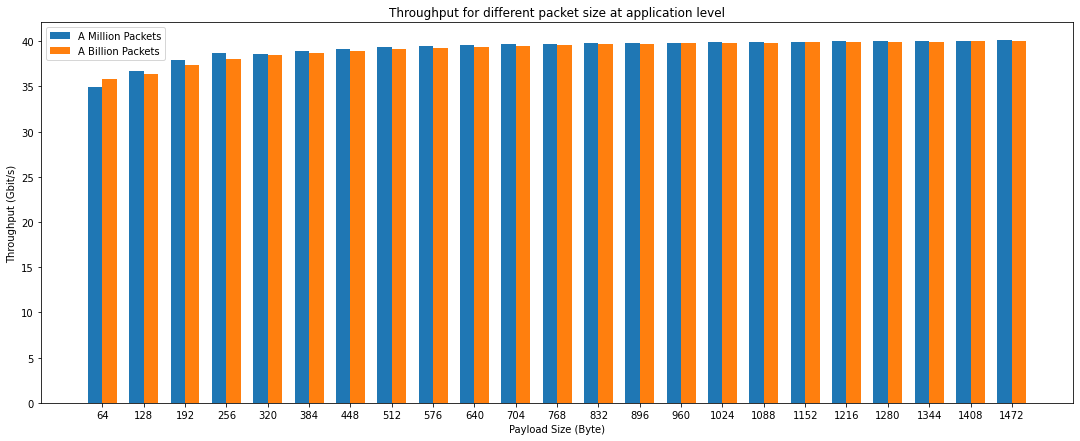

In [378]:
%matplotlib inline
import matplotlib.pyplot as plt

dict_oneM = experiment_dict[1_000_000]
dict_oneB = experiment_dict[1_000_000_000]
labels = []
oneM_thr = []
oneB_thr = []

for b in dict_oneM:
    labels.append(dict_oneM[b]['size'])
    # oneM_thr.append(dict_oneM[b]['rx_thr']
    dict_oneM[b]['pkt_thr'] = dict_oneM[b]['rx_thr'] * ((dict_oneM[b]['size'] + 46) / (dict_oneM[b]['size']))
    oneM_thr.append(dict_oneM[b]['rx_thr'] * ((dict_oneM[b]['size'] + 46) / (dict_oneM[b]['size'])))

for b in dict_oneB:
    # oneB_thr.append(dict_oneB[b]['rx_thr'])
    oneB_thr.append(dict_oneB[b]['rx_thr'] * ((dict_oneB[b]['size'] + 46) / (dict_oneB[b]['size'])))

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, oneM_thr, width, label='A Million Packets')
rects2 = ax.bar(x + width/2, oneB_thr, width, label='A Billion Packets')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Throughput (Gbit/s)')
ax.set_xlabel('Payload Size (Byte)')
ax.set_title('Throughput for different packet size at application level')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
# ax.set_ylim(40,100)
fig.set_size_inches(18.5, 7)
plt.show()

In [383]:
for b in dict_oneM:
    print(dict_oneM[b]["size"], dict_oneM[b]["pkt_thr"])

64 34.94440719046657
128 36.701029361316394
192 37.92180611892777
256 38.7056260238272
320 38.6464697807204
384 38.946739568156396
448 39.172193769416516
512 39.347998296205425
576 39.4385839756966
640 39.55348286502699
704 39.649371092352766
768 39.70025019104319
832 39.769802742128135
896 39.83014689597716
960 39.862620772846796
1024 39.90914474278075
1088 39.95050686867915
1152 39.97299781846425
1216 40.00633316564152
1280 40.036496539187304
1344 40.06392147720196
1408 40.07797949074557
1472 40.10095744974103


## Release Alveo cards
To release the alveo cards the pynq overlay is freed

In [81]:
pynq.Overlay.free(ol_w0)

------------------------------------------
Copyright (c) 2020-2021, Xilinx, Inc.